# Metody probabilistyczne

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Ryzyko kredytowe

Każda instytucja udzielająca kredytu musi szacować zdolność kredytową i prawdopodobieństwo, czy dana osoba spłaci kredyt. W praktyce większość osób płaci prawidłowo, więc zamiast tego przewiduje się prawdopodobieństwo, że ktoś będzie miał opóźnienia w płatności w określonym czasie, tzw. **probability of default**. Jak sama nazwa wskazuje, nie jest to klasyfikacja binarna, tylko faktyczne prawdopodobieństwo, wykorzystywane przy ocenie ryzyka.

Wykorzystamy zbiór z konkursu [Give Me Some Credit](https://www.kaggle.com/c/GiveMeSomeCredit/overview). Jego zmienne to ([źródło](https://www.listendata.com/2019/08/datasets-for-credit-risk-modeling.html)):
- `SeriousDlqin2yrs` - brak spłaty raty kredytu przez 90 dni lub dłużej w ciągu ostatnich 2 lat; są to nasze klasy `y`
- `RevolvingUtilizationOfUnsecuredLines` - aktualne zapożyczenie na kartach kredytowych i pożyczkach w stosunku do maksymalnego możliwego zapożyczenia
- `age` - wiek w latach
- `DebtRatio` - aktualne całkowite zapożyczenie względem miesięcznego dochodu
- `MonthlyIncome` - miesięczne dochody
- `NumberOfOpenCreditLinesAndLoans` - liczba aktualnych pożyczek i kart kredytowych
- `NumberOfTimes90DaysLate` - ile razy w przeszłości wystąpiło opóźnienie 90 dni lub dłużej w spłacie raty kredytu
- `NumberRealEstateLoansOrLines` - liczba pożyczek z nieruchomością jako zabezpieczeniem
- `NumberOfDependents` - liczba pozostałych osób w gospodarstwie domowym
- `NumberOfTime30-59DaysPastDueNotWorse` - ile razy w ciągu ostatnich 2 lat nastąpiło opóźnienie w spłacie raty między 30 a 59 dni
- `NumberOfTime60-89DaysPastDueNotWorse` - jak wyżej, ale 60-89 dni

Ze względu na potrzebę precyzyjnych prawdopodobieństw oraz rozmiar danych (banki mają ogromną liczbę klientów), regresja logistyczna to idealny wybór dla tego zadania. Metryką w takich przypadkach jest AUROC (Area Under Receiver Operating Characteristic curve), bo bierze ona pod uwagę prawdopodobieństwo klasy pozytywnej.

Na początek wczytamy i przeanalizujemy wstępnie nasze dane. Jako zbiór testowy wykorzystamy 20% danych. Jako że mamy do czynienia z klasyfikacją niezbalansowaną, to wykorzystamy **podział ze stratyfikacją (stratified split)**, w którym proporcje klasy pozytywnej i negatywnej zostają zachowane w zbiorze treningowym i testowym.

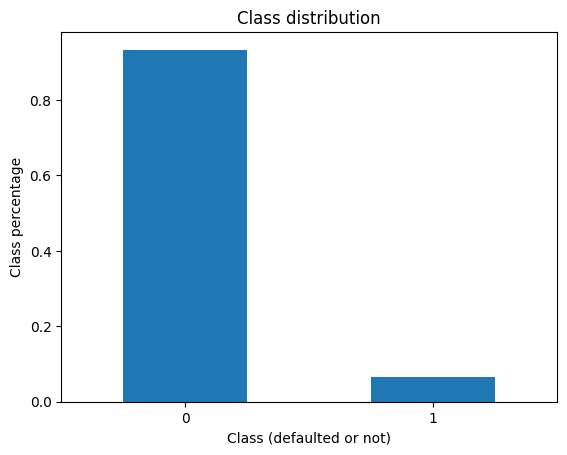

In [2]:
from sklearn.model_selection import train_test_split


df = pd.read_parquet("give_me_some_credit_data.parquet")
y = df.pop("SeriousDlqin2yrs")
X = df

y.value_counts(normalize=True).plot.bar(
    title="Class distribution",
    rot=0,
    xlabel="Class (defaulted or not)",
    ylabel="Class percentage",
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=0
)

Jako że naszych zmiennych nie jest zbyt wiele, możemy łatwo zweryfikować statystyki naszych danych z pomocą metod `.info()` oraz `.describe()`:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 10 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 1   age                                   150000 non-null  int64  
 2   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 3   DebtRatio                             150000 non-null  float64
 4   MonthlyIncome                         120269 non-null  float64
 5   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 6   NumberOfTimes90DaysLate               150000 non-null  int64  
 7   NumberRealEstateLoansOrLines          150000 non-null  int64  
 8   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 9   NumberOfDependents                    146076 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 11.4 MB


Mamy wartości brakujące w `MonthlyIncome` oraz `NumberOfDependents`. Tutaj z ekonomii wiadomo, że imputacja medianą będzie bardzo dobrym wyborem.

In [4]:
df.describe()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


W takiej tabeli warto patrzeć na średnią, odchylenie standardowe i maksimum dla każdej cechy. Mamy tutaj ewidentne outliery! Przykładowo, dla `DebtRatio`:
- średnio 353
- odchylenie standardowe 2037
- maksimum >300 tysięcy

Trzeba to będzie naprawić. Dodatkowo, nawet abstrahując od tych outlierów, patrząc na statystyki można podejrzewać dość mocno skrzywione rozkłady (co jest dość normalne w ekonomii). W takich sytuacjach lepiej używać tzw. robust statistics, na przykład mediany zamiast średniej, czy też IQR zamiast odchyleń standardowych.

**Zadanie 1 (1.5 punktu)**

1. Dokonaj imputacji danych medianą (`SimpleImputer`) oraz standaryzacji (`StandardScaler`).
2. Wytrenuj regresję logistyczną z domyślnymi hiperparametrami (`LogisticRegression`). Pamiętaj o `n_jobs=-1` (mamy dużo danych) i ustawieniu `random_state=0`. Zmierz AUROC na zbiorze testowym.
3. Dodaj usuwanie outlierów pomiędzy imputacją a standaryzacją. Skorzystaj z biblioteki feature-engine oraz klasy `OutlierTrimmer` (domyślne parametry). Wytrenuj na nowo model i porówaj wyniki.
4. Dodaj `Winsorizer` pomiędzy usuwaniem outlierów a standaryzacją, który przytnie wartości zmiennych do zakresu między średnią a 3 odchyleniami standardowymi z góry (po usunięciu outlierów powinny mieć sensowne wartości). Ponownie wytrenuj i przetestuj model.

W punkcie 3 filtrujemy także wiersze ze zbioru testowego. Niektórzy uznaliby to za niedopuszczalne, ale warto zwrócić uwagę, że usuwamy tutaj outliery uznawane za błędy, więc z drugiej strony testowanie na nich też daje błędny obraz sytuacji. Można więc to uznać za dopuszczalne, jeżeli dobrze wiemy, co robimy, i estymujemy parametry do usuwania tylko na zbiorze treningowym.

Przyda się używać innych nazw zmiennych niż `X_train` i `X_test`, żeby nie nadpisać sobie danych w kolejnych krokach.

**Uwaga:** upewnij się, że prawidłowo liczysz AUROC, przekazując do niego prawdopodobieństwa klasy pozytywnej!

In [5]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

standard_pipeline = Pipeline([["imputer", imputer], ["scaler", scaler]])

X_train_standard = standard_pipeline.fit_transform(X_train)
X_test_standard = standard_pipeline.transform(X_test)

log_reg_standard = LogisticRegression(n_jobs=-1, random_state=0)
log_reg_standard.fit(X_train_standard, y_train)

y_pred_standard = log_reg_standard.predict_proba(X_test_standard)

score_standard = roc_auc_score(y_test, y_pred_standard[:, 1])

In [6]:
from feature_engine.outliers import OutlierTrimmer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

imputer = SimpleImputer(strategy="median")
trimmer = OutlierTrimmer()
scaler = StandardScaler()

X_train_trimmed = imputer.fit_transform(X_train)
X_test_trimmed = imputer.transform(X_test)

trimmer.fit(X_train_trimmed)
X_train_trimmed, y_train_trimmed = trimmer.transform_x_y(X_train_trimmed, y_train)
X_test_trimmed, y_test_trimmed = trimmer.transform_x_y(X_test_trimmed, y_test)

X_train_trimmed = scaler.fit_transform(X_train_trimmed)
X_test_trimmed = scaler.transform(X_test_trimmed)

log_reg_trimmed = LogisticRegression(n_jobs=-1, random_state=0)
log_reg_trimmed.fit(X_train_trimmed, y_train_trimmed)

y_pred_trimmed = log_reg_trimmed.predict_proba(X_test_trimmed)

score_trimmed = roc_auc_score(y_test_trimmed, y_pred_trimmed[:, 1])

In [7]:
from feature_engine.outliers import OutlierTrimmer, Winsorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

imputer = SimpleImputer(strategy="median")
trimmer = OutlierTrimmer()
winsorizer = Winsorizer()
scaler = StandardScaler()

X_train_winsorized = imputer.fit_transform(X_train)
X_test_winsorized = imputer.transform(X_test)

trimmer.fit(X_train_winsorized)
X_train_winsorized, y_train_winsorized = trimmer.transform_x_y(
    X_train_winsorized, y_train
)
X_test_winsorized, y_test_winsorized = trimmer.transform_x_y(X_test_winsorized, y_test)

X_train_winsorized = winsorizer.fit_transform(X_train_winsorized)
X_test_winsorized = winsorizer.transform(X_test_winsorized)

X_train_winsorized = scaler.fit_transform(X_train_winsorized)
X_test_winsorized = scaler.transform(X_test_winsorized)

log_reg_winsorized = LogisticRegression(n_jobs=-1, random_state=0)
log_reg_winsorized.fit(X_train_winsorized, y_train_winsorized)

y_pred_winsorized = log_reg_winsorized.predict_proba(X_test_winsorized)

score_winsorized = roc_auc_score(y_test_winsorized, y_pred_winsorized[:, 1])

In [8]:
print("Scores")
print("=" * 27)
print(f"Standard: {score_standard:.2f}")
print(f"Trimmed: {score_trimmed:.2f}")
print(f"Trimmed + Winsorized: {score_winsorized:.2f}")

Scores
Standard: 0.71
Trimmed: 0.83
Trimmed + Winsorized: 0.85


Teraz mamy faktycznie czysty zbiór danych i wytrenowane pierwsze modele. Warto zwrócić jednak uwagę na dwa fakty:
1. Nie dokonaliśmy żadnego tuningu siły regularyzacji, na którą regresja logistyczna jest czuła
2. Mamy mocno niezbalansowane klasy, a uwzględniamy je z taką samą wagą

**Zadanie 2 (1 punkt)**

1. Dokonaj tuningu siły regularyzacji:
   - sprawdź 100 wartości `C` (odwrotność siły regularyzacji, jak w SVM)
   - wykorzystaj `LogisticRegressionCV`
   - wybierz model o najlepszej wartości AUROC (`scoring`)
   - pamiętaj o `random_state=0`
   - sprawdź wynik modelu na zbiorze testowym
2. Dodaj zbalansowane wagi klas (`class_weight`), z tuningiem siły regularyzacji jak wyżej. Przetestuj model.
3. Dla porównania, wytrenuj las losowy (`RandomForestClassifier`) z 500 drzewami i zbalansowanymi wagami klas, i sprawdź wyniki.
4. Skomentuj wyniki:
   - czy twoim zdaniem to ogólnie dobry wynik dla takiego problemu?
   - czy warto było poświęcić czas na preprocessing danych?
   - jak wypadła regresja logistyczna w porównaniu do lasu losowego? Czy jest do dla ciebie oczekiwany, czy zaskakujący wynik?

In [9]:
from sklearn.linear_model import LogisticRegressionCV

log_reg_cv = LogisticRegressionCV(
    Cs=np.linspace(1e-2, 1e2, num=100),
    random_state=0,
    n_jobs=-1,
    scoring="roc_auc",
    cv=5,
)

log_reg_cv.fit(X_train_winsorized, y_train_winsorized)

y_pred_cv = log_reg_cv.predict_proba(X_test_winsorized)
score_cv = roc_auc_score(y_test_winsorized, y_pred_cv[:, 1])
best_C_cv = log_reg_cv.C_[0]

In [10]:
from sklearn.linear_model import LogisticRegressionCV

log_reg_cv_balanced = LogisticRegressionCV(
    Cs=np.linspace(1e-2, 1e2, num=100),
    random_state=0,
    n_jobs=-1,
    scoring="roc_auc",
    cv=5,
    class_weight="balanced",
)

log_reg_cv_balanced.fit(X_train_winsorized, y_train_winsorized)

y_pred_cv_balanced = log_reg_cv_balanced.predict_proba(X_test_winsorized)
score_cv_balanced = roc_auc_score(y_test_winsorized, y_pred_cv_balanced[:, 1])
best_C_balanced = log_reg_cv_balanced.C_[0]

In [11]:
from sklearn.ensemble import RandomForestClassifier


forest = RandomForestClassifier(
    n_estimators=500, class_weight="balanced", random_state=0, n_jobs=-1
)

forest.fit(X_train_winsorized, y_train_winsorized)

y_pred_forest = forest.predict_proba(X_test_winsorized)
score_forest = roc_auc_score(y_test_winsorized, y_pred_forest[:, 1])

In [12]:
print("Scores")
print("=" * 28)
print(f"Tuned LogisiticRegression AUROC: {score_cv:.2f}, best C: {best_C_cv}")
print(
    f"Tuned LogisiticRegression AUROC with balanced classes: {score_cv_balanced:.2f}, best C: {best_C_balanced}"
)
print(f"RandomForest AUROC: {score_forest:.2f}")

Scores
Tuned LogisiticRegression AUROC: 0.85, best C: 1.02
Tuned LogisiticRegression AUROC with balanced classes: 0.86, best C: 0.01
RandomForest AUROC: 0.85


- Wydaje mi się, że wynik jest raczej dobry. Potrafimy dobrze przewidzieć 85% przypadków, gdzie ktoś będzie zalegał z kredytem.
- Warto, bo przeszliśmy z 71% -> 85%
- Wypadła niemal identycznie - nie wiem czy to zaskakujące.

Sprawdźmy jeszcze, jak dobrze nam idzie z predykcjami prawdopodobieństwa. Regresja logistyczna jest z natury dobrze skalibrowana, ale nie ma takiej gwarancji na każdym zbiorze danych. W szczególności może mieć problemy na zbiorach niezbalansowanych, przez bardzo niewielką ilość klasy pozytywnej (a priori jest rzadka).

Do rysowania krzywych kalibracji służy klasa `CalibrationDisplay`. W perfekcyjnym przypadku prawdopodobieństwa modelu rosną liniowo raz z "pewnością", że punkt należy do klasy pozytywnej. Dla zainteresowanych, [dokumentacja Scikit-learn](https://scikit-learn.org/stable/modules/calibration.html#calibration-curves) omawia te krzywe nieco dokładniej.

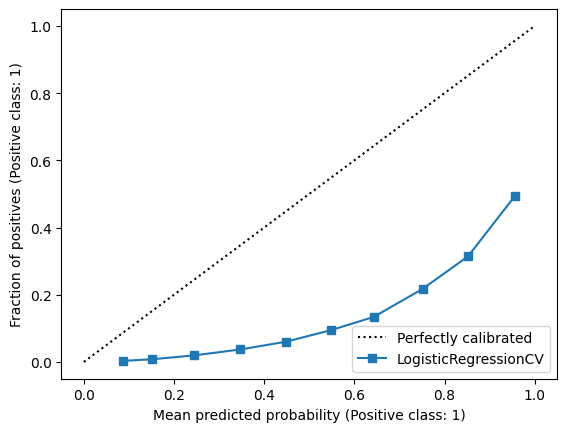

In [13]:
from sklearn.calibration import CalibrationDisplay

clf = log_reg_cv_balanced  # put model variable from last exercise here

CalibrationDisplay.from_estimator(clf, X_test_winsorized, y_test_winsorized, n_bins=10)

Krótko mówiąc, nie jest dobrze! Nasz model praktycznie zawsze bardzo mocno zaniża prawdopodobieństwo. W połączeniu z wysokim AUROC oznacza to, że w klasyfikacji generalnie nieźle sobie radzi, dla rosnącego prawdopodobieństwa dość szybko przypisuje punkt do klasy pozytywnej, ale finalne wartości prawdopodobieństw są notorycznie zbyt niskie.

Do poprawienia tej sytuacji służy `CalibratedClassifierCV`, który na podstawie predykcji naszego modelu oraz zbioru treningowego dotrenowuje dodatkowy model do doprecyzowania prawdopodobieństw. Może być to albo regresja logistyczna, albo tzw. regresja izotoniczna ([isotonic regression](https://scikit-learn.org/stable/modules/isotonic.html#isotonic)) - specjalny model wykorzystujący fakt, że prawdopodobieństwa są stricte rosnące od 0 do 1.

**Zadanie 3 (1 punkt)**

Wytrenuj kalibrator prawdopodobieństwa z pomocą `CalibratedClassifierCV`. Wykorzystaj tryb regresji izotonicznej i 10-krotną walidację skrośną. Przekaż do niego wytrenowany estymator wykorzystany w poprzednim ćwiczeniu. Narysuj krzywą kalibracji na zbiorze testowym, jak w poprzednim przykładzie.

Skomentuj, jak udało się poprawić kalibrację modelu. Czy twoim zdaniem taki model przewiduje już dość dobrze prawdopodobieństwa?

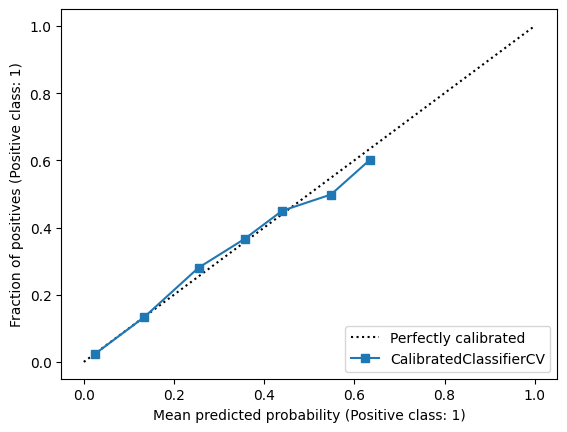

In [14]:
from sklearn.calibration import CalibratedClassifierCV


calibrated_cv = CalibratedClassifierCV(
    estimator=log_reg_cv_balanced, method="isotonic", cv=10, n_jobs=-1
)
calibrated_cv.fit(X_train_winsorized, y_train_winsorized)

CalibrationDisplay.from_estimator(
    calibrated_cv, X_test_winsorized, y_test_winsorized, n_bins=10
)

Udało się znacząco poprawić kalibrację modelu. Sądząc po wykresie, model jest w stanie już dobrze przewidzieć prawdopodobieństwa.

## Detekcja spamu

Wykorzystamy teraz klasyfikator Naiwnego Bayesa do klasyfikacji binarnej tekstów - czy email jest spamem, czy też nie (tzw. "ham"). Takie zadanie nazywa się też spam/ham classification. Zbiorem będzie [Enron Spam dataset](http://nlp.cs.aueb.gr/software_and_datasets/Enron-Spam/index.html), zebrany na potrzeby artykułu:

> Metsis, Vangelis, Ion Androutsopoulos, and Georgios Paliouras. *"Spam filtering with Naive Bayes - which Naive Bayes?."* CEAS. Vol. 17. 2006. [link](https://userweb.cs.txstate.edu/~v_m137/docs/papers/ceas2006_paper_corrected.pdf)

[Upadek firmy energetycznej Enron](https://userweb.cs.txstate.edu/~v_m137/docs/papers/ceas2006_paper_corrected.pdf) i skandal wywołany wiadomościami o nieprawidłowościach finansowych spowodowały, że podczas śledztwa i procesu zmuszono firmę do upublicznienia pełnej zawartości skrzynek mailowych 150 pracowników. Jest to doskonałe źródło prawdziwych danych, typowych emaili niebędących spamem, i było wykorzystywane wielokrotnie na potrzeby tworzenia wielu różnych zbiorów danych. Na potrzeby powyższego artykułu wybrano 6 pracowników z dużą liczbą emaili.

Maile będące spamem otrzymano z 4 różnych źródeł:
1. [Zbioru danych SpamAssassin](https://spamassassin.apache.org/old/publiccorpus/) - stworzony z pomocą [Apache SpamAssassin](https://spamassassin.apache.org/), narzędzia open source do detekcji spamu. Maile niebędące spamem są w nim bardzo specyficzne (pochodzą ze skrzynek fundacji Apache i dotyczą praktycznie tylko programownaia), za to spam jest uniwersalny.
2. [Project Honeypot](https://www.projecthoneypot.org/) - projekt mający na celu wykrywanie spammerów (w tym przez specjalne pułapki, tzw. spam baiting) i tworzenie baz do filtrowania spamu.
3. [Bazę spamu Bruce'a Guentera](http://untroubled.org/spam/) - gromadzi on cały spam, który dostaje na skrzynki (w tym takie do spam baitingu) od 1997 roku.
4. Maile ze spamem zgromadzone przez trzeciego autora artykułu, Georgiosa Paliourasa.

Artykuł prezentuje spersonalizowane kolekcje maili, dla każdego z 6 wybranych pracowników Enronu. My natomiast połączymy wszystkie dane i stworzymy prosty, uniwersalny filtr. Nasz filtr będzie operował tylko na tytułach i treści maili - realnie wdrażane systemy są dużo bardziej rozbudowane i wykorzystują metadane, bazy adresów, analizę tagów HTML i XML etc.

Wykorzystamy przetworzoną postać tego zbioru w postaci pliku CSV z interesującymi nas elementami. Skrypt do tego wzięto [z tego repozytorium na Githubie](https://github.com/MWiechmann/enron_spam_data?fbclid=IwAR1icPxic8TDD6HGk6empohwcZ76uig0NxwxK7sWbczinBNfxEEt-ETparA).

In [15]:
df = pd.read_csv("enron_spam_data.csv")
df

,Message ID,Subject,Message,Spam/Ham,Date
0,0,christmas tree farm pictures,NaN,ham,1999-12-10
1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham,1999-12-13
2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,1999-12-14
3,3,re : issue,fyi - see note below - already done .\nstella\...,ham,1999-12-14
4,4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham,1999-12-14
...,...,...,...,...,...
33711,33711,= ? iso - 8859 - 1 ? q ? good _ news _ c = eda...,"hello , welcome to gigapharm onlinne shop .\np...",spam,2005-07-29
33712,33712,all prescript medicines are on special . to be...,i got it earlier than expected and it was wrap...,spam,2005-07-29
33713,33713,the next generation online pharmacy .,are you ready to rock on ? let the man in you ...,spam,2005-07-30
33714,33714,bloow in 5 - 10 times the time,learn how to last 5 - 10 times longer in\nbed ...,spam,2005-07-30


Na pierwszy rzut oka widać parę problemów:
- kolumny `Message ID` i `Date` są niepotrzebne
- niektóre wiadomości mają tylko tytuł lub tylko wiadomość
- klasa jest zapisana jako string spam/ham

**Zadanie 4 (0.5 punktu)**

1. Uzupełnij wartości brakujące w kolumnach `Subject` i `Message` pustymi stringami.
2. Połącz kolumny `Subject` i `Message` w jedną kolumnę `text`, ze spacją pomiędzy nimi. Może się przydać metoda `pd.Series.str.cat()`. Wyodrębnij ją do nowej zmiennej `texts`.
3. Zamień wartość `ham` na 0 i `spam` na 1 w kolumnie `Spam/Ham`. Wyodrębnij ją do nowej zmiennej `y`.

In [16]:
df["Subject"] = df["Subject"].fillna("")
df["Message"] = df["Message"].fillna("")

texts = df["Subject"].str.cat(df["Message"], sep=" ")

y = df["Spam/Ham"].map({"ham": 0, "spam": 1})

Sprawdźmy jeszcze rozkład klas.

[Text(0, 0, '50.93'), Text(0, 0, '49.07')]

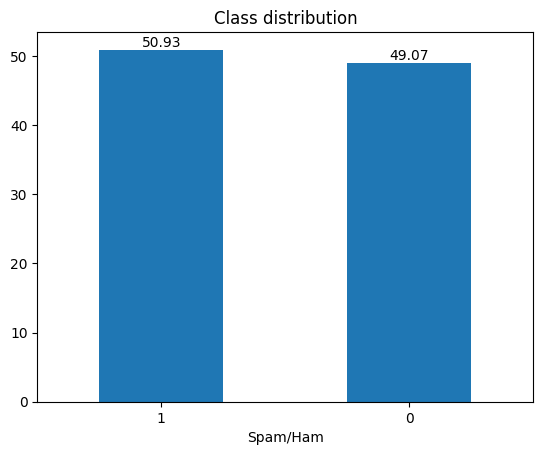

In [17]:
class_percentages = y.value_counts(normalize=True)
class_percentages = round(class_percentages * 100, 2)

ax = class_percentages.plot.bar(title="Class distribution", rot=0)

ax.bar_label(ax.containers[0])

Ten zbiór w całości jest o tyle specyficzny, że dodano tutaj aż tyle spamu, że jest go nawet więcej niż zwykłych emaili. W praktyce spamu jest dużo mniej, ok. 1/3 maili. Tutaj uznajemy, że klasy są zbalansowane.

Typową metryką w klasyfikacji spamu jest **precyzja (precision)**, bo wyznacza ona, jak dobrzy jesteśmy w oznaczaniu spamu. Recall ma mniejsze znaczenie, bo bardziej zależy nam na minimalizacji FP - ważne maile nie mogą trafiać do spamu, natomiast jeżeli spam czasem trafi do zwykłej skrzynki (FN), to nie ma wielkiego znaczenia. Często używa się też F1-score jako metryki.

W przypadku tych metryk (precision/recall/F1-score) zawsze trzeba sprawdzić co najmniej dwie z nich, żeby uniknąć przypadkiem sytuacji, że mamy np. precision bliskie 100%, a dramatycznie niski recall - to też nie byłoby akceptowalne. Trzeba też uważać podczas walidacji skrośnej - np. klasyfikator przewidujący cały czas klasę pozytywną miałby 100% recall, a cały czas negatywną 100% precision, więc typowo najwygodniej jest optymalizować F1-score.

Na początek podzielimy zbiór na treningowy i testowy. Naszymi cechami będą zliczenia wystąpień poszczególnych słów, obliczone z pomocą klasy `CountVectorizer` ([dokumentacja](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)). Na start podamy `binary=True`, dzięki czemu cechy będą binarne - czy słowo wystąpiło, czy nie. Dzięki temu będziemy mogli użyć Naiwnego Bayesa z rozkładem dwumianowym - `BernoulliNB`. Wykonamy minimalny preprocessing, usuwając tylko tzw. stop words, czyli "nudne", niepotrzebne słowa, typu "he", "she", "the" etc.

Zauważ, że wejściem do metody `.fit()` jest lista tekstów, ze względu a domyślne `input="content"`. Można by tu też wskazać listę ścieżek do plików z tekstami (`input="filename"`).

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB


texts_train, texts_test, y_train, y_test = train_test_split(
    texts,
    y,
    test_size=0.25,
    random_state=0,
    stratify=y,
)

count_vectorizer = CountVectorizer(
    stop_words="english",
    binary=True,
)
count_vectorizer.fit(texts_train)

X_train = count_vectorizer.transform(texts_train)
X_test = count_vectorizer.transform(texts_test)

print(f"Dictionary size: {X_train.shape[1]}")

clf_nb_bernoulli = BernoulliNB(binarize=None)
clf_nb_bernoulli.fit(X_train, y_train)

y_pred = clf_nb_bernoulli.predict(X_test)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {100 * precision:.2f}%")
print(f"F1-score: {100 * f1:.2f}%")

Dictionary size: 139189
Precision: 98.92%
F1-score: 98.46%


Wynik jest prawie doskonały. Może uda się jeszcze wycisnąć ten ostatni procent?

**Zadanie 5 (2 punkty)**

1. Oblicz wystąpienia słów bez binaryzacji, otrzymując drugi zbiór cech.
2. Wytrenuj model multinomial Naive Bayes na otrzymanym zbiorze. Sprawdź precyzję i F1-score na zbiorze testowym.
3. Stwórz `Pipeline` z połączenia `CountVectorizer` i `MultinomialNB`. Podaj te opcje, co wcześniej do CountVectorizera.
4. Dokonaj tuningu hiperparametrów:
   - `ngram_range` - jakie n-gramy rozważać, sprawdź wartości `[(1, 1), (1, 2), (1, 3)]` (same słowa, + bigramy, + bigramy i trigramy)
   - `max_df` - w jakim maksymalnie ułamku tekstów w zbiorze może wystąpić słowo, sprawdź wartości `[0.5, 0.6, 0.7, 0.8, 0.9, 1.0]`
   - wybierz model o najwyższej precyzji
   - użyj standardowych ustawień: 5-krotna walidacja skrośna, `n_jobs=-1`
   - sprawdź precyzję i F1-score na zbiorze testowym dla znalezionych optymalnych hiperparametrów
5. Wypisz optymalne hiperparametry. Sprawdź, jak zmienił się rozmiar słownika przy tych hiperparametrach.
6. Skomentuj uzyskane hiperparametry. Jaki zakres (kontekst) uwzględniamy przy takich n-gramach? Czy uwzględniamy wszystkie słowa/bigramy/trigramy?

**Uwaga:**
1. Do metody `.fit()` możesz przekazać `texts_train` i `y_train`. Jako że `CountVectorizer` ma interfejs transformera (ma metodę `.transform()`), to Scikit-learn przekształci nim teksty do macierzy `X_train` i to ją przekaże dalej do klasyfikatora.
2. Przy tworzeniu pipeline'u może się przydać [ta odpowiedź na StackOverflow](https://stackoverflow.com/a/64258746/9472066).
3. Pamiętaj, że do testowania też trzeba przekazać teksty, które przekształcimy w środku pipeline'u.

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB


texts_train, texts_test, y_train, y_test = train_test_split(
    texts,
    y,
    test_size=0.25,
    random_state=0,
    stratify=y,
)

count_vectorizer = CountVectorizer(
    stop_words="english",
    binary=False,
)

count_vectorizer.fit(texts_train, y_train)

X_train = count_vectorizer.transform(texts_train)
X_test = count_vectorizer.transform(texts_test)

multi_naive_bayes = MultinomialNB()
multi_naive_bayes.fit(X_train, y_train)

y_pred = multi_naive_bayes.predict(X_test)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {100 * precision:.2f}%")
print(f"F1 Score: {100 * f1:.2f}%")

Precision: 98.54%
F1 Score: 98.71%


In [20]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, f1_score

pipeline = Pipeline(
    [
        ("count_vectorizer", CountVectorizer(stop_words="english", binary=False)),
        ("multinomial_nb", MultinomialNB()),
    ]
)

parameters = {
    "count_vectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)],
    "count_vectorizer__max_df": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
}

grid_search = GridSearchCV(
    estimator=pipeline, param_grid=parameters, cv=5, n_jobs=-1, scoring="precision"
)
grid_search.fit(texts_train, y_train)

best_params = grid_search.best_params_
y_pred = grid_search.predict(texts_test)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Best Parameters: {best_params}")
print(f"Test Precision: {100 * precision:.2f}%")
print(f"Test F1-Score: {100 * f1:.2f}%")

Best Parameters: {'count_vectorizer__max_df': 0.5, 'count_vectorizer__ngram_range': (1, 3)}
Test Precision: 99.32%
Test F1-Score: 99.24%


In [21]:
best_count_vectorizer = CountVectorizer(
    stop_words="english", binary=False, max_df=0.5, ngram_range=(1, 3)
)
print(
    f"Dictionary size: {best_count_vectorizer.fit_transform(texts_train, y_train).shape[1]}"
)

Dictionary size: 3383053


- Rozmiar słownik zwiększył się 30-krotnie
- Uwzględniamy same słowa, digramy i trigramy. W każdym z nich może wystąpić tylko jedno słowo spamowe.

W przypadku tak wysokich wyników raczej nie ma sensu sprawdzać bardziej złożonych technik, typu ważenie słów (TF-IDF, BM25), upraszczanie słów (stemming, lematyzacja) etc. W przypadku bardziej złożonych tekstów mogłoby to być przydatne.

Naiwnego Bayesa do klasyfikacji tekstu używa się obecnie relatywnie rzadko. Potrafi on jednak działać równie dobrze, jak transformery, kiedy dla danego zadania mają znaczenie same wystąpienia słów czy tematyka tekstu, a nie dokładna semantyka zdań. Naiwny Bayes jest przy tym oczywiście bez porównania prostszy i szybszy.

## Dane z ekspresji genów

Naszym ostatnim zbiorem będzie [GSE14520](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE14520), opublikowany przez [SBCB Lab](https://sbcb.inf.ufrgs.br/cumida)). Jest to zbiór ekspresji genów z sekwencjonowania RNA, zebrany na potrzeby artykułu:

> Feltes, B.C.; Chandelier, E.B.; Grisci, B.I.; Dorn, M. (2019) *"CuMiDa: An Extensively Curated Microarray Database for Benchmarking and Testing of Machine Learning Approaches in Cancer Research"*. Journal of Computational Biology, 26 (4), 376-386. [link](https://sci-hub.se/10.1089/cmb.2018.0238)

Dane o ekspresji DNA pozwalają na analizę genetyczną i związku pomiędzy genomem pacjenta a podatnością na choroby. Jest to szczególnie istotne w kontekście nowotworów, gdyż wiele ich typów powstaje przez błędy właśnie w procesie ekspresji genów. Mikromacierze (microarrays) służą do przetwarzania i analizy danych dużej skali w genetyce i dostarczają danych o ogromnej liczbie danych pacjenta. Oczywiście samo gromadzenie próbek, gdzie każdą jest osobny pacjent, jest bardzo drogie. Daje to zbiory danych o bardzo małej liczbie próbek, nawet zaledwie kilkudziesięciu czy kilkuset, a za to dziesiątki tysięcy cech.

Zbiór CuMiDa zawiera 78 zbiorów danych, wybranych z bazy GEO (Gene Expression Omnibus) i poddanych preprocessingowi, np. normalizacji danych pomiędzy płytkami pomiarowymi różnych typów. Wynikowe zadania dotyczą klasyfikacji czy detekcji nowotworu na podstawie analizy genomu pacjenta. Cechy w zbiorach danych dotyczą siły ekspresji poszczególnych genów, a konkretnie znormalizowanej wartości - czy gen jest słabiej, czy silniej wykazywany u danej osoby względem grupy kontrolnej. Są one na etapie preprocessingu standaryzowane do z-score (odjęcie średniej, podzielenie przez odchylenie standardowe), co skutkuje danymi o podobnej skali, bardziej zbliżonym rozkładzie, i pozwala porównywać ze sobą dane poszczególnych pacjentów.

Użyjemy zbioru GSE 14520, który jest największym z kolekcji CuMiDa i zawiera 357 próbek oraz 22278 genów. Dotyczy klasyfikacji tkanek nowotoworowych (klasa pozytywna) vs zdrowych (klasa negatywna) dla raka wątrobowokomórkowowego wątroby (hepatocellular carcinoma, HCC). Jest to często występujący, a przy tym bardzo złośliwy nowotwór (trzeci najbardziej śmiertelny), będący często skutkiem innych chorób wątroby.

Na start wczytamy dane, sprawdzimy rozkład klas, oraz zwizualizujemy rozkłady kilku przykładowych cech.

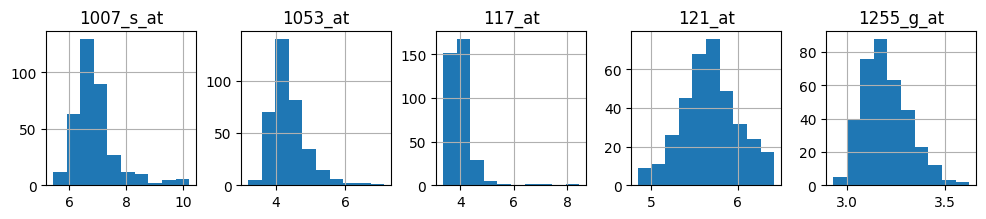

<Axes: title={'center': 'Class distribution'}, xlabel='type'>

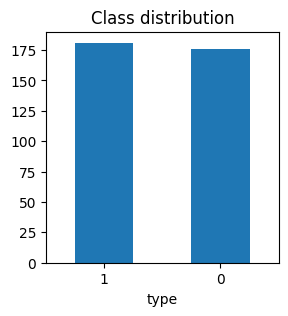

In [22]:
df = pd.read_csv("Liver_GSE14520_U133A.csv")

y = df["type"].map({"normal": 0, "HCC": 1})
df = df.drop(columns=["samples", "type"])

fig, ax = plt.subplots(1, 5, figsize=(12, 2))
for i in range(5):
    df.hist(column=df.columns[i], ax=ax[i])

plt.show()

pd.Series(y).value_counts().plot.bar(title="Class distribution", rot=0, figsize=(3, 3))

**Zadanie 6 (1 punkt)**

Ze względu na niewielki rozmiar takich zbiorów, walidacji skrośnej używa się **do testowania**. Podział na zbiór treningowy i testowany jest wykonywany na kolejnych foldach. Dla ekstremalnie małych zbiorów można też wykorzystać **Leave-One-Out Cross-Validation (LOOCV)**, gdzie zbiór testowy to jedna próbka naraz. W razie potrzeby tuningu hiperparametrów można też wykonać wewnętrzną walidację skrośną na aktualnym foldzie treningowym - technikę tę nazywamy **nested cross-validation (nested CV)**.

1. Dokonaj podziału na zbiór treningowy i testowy z pomocą 3-fold CV (klasa [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)), analogicznie do oryginalnego artykułu. Wykorzystaj losową kolejność (`shuffle=True`) oraz stały `random_state=0`.
2. Wytrenuj klasyfikator [GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html).
3. Dokonaj walidacji na zbiorach testowych, wykorzystując celność (accuracy).
4. Wypisz wartość średnią (w procentach) celności na danych testowych, oraz odchylenie standardowe, oba zaokrąglone do 2 miejsca po przecinku.
5. Zmierz czas dla całości procesu, np. z pomocą modułu `time` lub biblioteki `tqdm`.
6. Porównaj wyniki z oficjalnymi podanymi [na stronie SBCB Lab](https://sbcb.inf.ufrgs.br/cumida) dla tego zbioru danych - jak dobrze radzi sobie klasyfikator Naiwnego Bayesa?

In [23]:
from time import time
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB

scores = []
kf = KFold(n_splits=3, random_state=0, shuffle=True)
gaussian_nb = GaussianNB()

start_time = time()

for i, (train_idxs, test_idxs) in enumerate(kf.split(df)):
    # Split data into training and testing sets
    X_train = df.iloc[train_idxs]
    y_train = y.iloc[train_idxs]
    X_test = df.iloc[test_idxs]
    y_test = y.iloc[test_idxs]

    # Train the model
    gaussian_nb.fit(X_train, y_train)

    # Predict and calculate accuracy
    y_pred = gaussian_nb.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    scores.append(score)

    print(f"Iteration #{i + 1} - Accuracy: {100 * score:.2f}%")

# Calculate mean and standard deviation of accuracy
mean_accuracy = np.mean(scores) * 100
std_accuracy = np.std(scores) * 100

end_time = time()

print(f"\nMean Accuracy: {mean_accuracy:.2f}%")
print(f"Standard Deviation: {std_accuracy:.2f}%")
print(f"Total Time: {end_time - start_time:.2f} seconds")

Iteration #1 - Accuracy: 96.64%
Iteration #2 - Accuracy: 94.12%
Iteration #3 - Accuracy: 96.64%

Mean Accuracy: 95.80%
Standard Deviation: 1.19%
Total Time: 0.61 seconds


Udało osiągnąć się podobny wynik co do tego oficjalnego na stronie. Klasyfikator radzi sobie świetnie na tle innych modeli.

Skoro mamy dobrze działający klasyfikator, to warto dobrze zrozumieć, jak działa pod spodem. Jest to też doskonała okazja, żeby nauczyć się, jak tworzyć własne klasyfikatory zgodne z API scikit-learn. Robi się w skrócie to tak ([dokładny tutorial](https://scikit-learn.org/stable/developers/develop.html)):
1. Tworzymy klasę dziedziczącą po `BaseEstimator`, `ClassifierMixin` oraz ewentualnie innych klasach, które nas interesują.
2. Wszystkie hiperparametry są argumentami konstruktora. Każdy jest przypisywany, bez żadnych zmian, do atrybutu o dokładnie tej samej nazwie.
3. Implementujemy metody `.fit(X, y)`,`.predict(X)`, oraz ewentualnie `.predict_proba(X)`.
4. Metoda `.fit()` musi zwracać `self`, a estymowane parametry przypisuje jako atrybuty (tworzone w `.fit()`) z underscore na końcu, np. `.weights_`. Często wywołuje się `np.asarray()` na `X` i `y`, żeby upewnić się, że będą to macierze NumPy'a.
5. Na początku metody `.fit(X, y)` używamy funkcji `check_X_y()`, żeby dokonać podstawowej walidacji wejścia. Na początku metody `.predict(X)` analogicznie używamy funkcji `check_array()` na wejściu `X`.

Taki interfejs gwarantuje, że nasz własny model będzie mógł być używany np. w `GridSearchCV`.

**Zadanie 7 (3 punkty)**

Uzupełnij implementację własnej klasy `CustomGaussianNB`, która będzie realizować Naiwnego Bayesa dla rozkładu normalnego.

1. Zakładamy, że klasy są liczbami całkowitymi, z wartościami `[0, 1, ..., liczba klas - 1]`.
2. Rozkład a priori (prior) dla każdej klasy to proporcja tej klasy w zbiorze treningowym. Naive Bayes używa log-sum-exp trick, więc można od razu obliczyć logarytm i zapisać log-prior.
3. Gaussian NB zakłada, że każda cecha w obrębie klasy ma rozkład normalny. Opisują go dwa parametry: średnia i wariancja. Będziemy więc mieli `2*K` parametrów dla `K` klas. Trzeba je wyestymować w metodzie `.fit()` i zapisać jako macierze parametrów, np. `.means_` i `.variances_`.
4. Do wariancji klas dodaj niewielką stałą, żeby uniknąć problemów numerycznych, np. 1e-9. Scikit-learn nazywa to `var_smoothing`.
5. Podczas predykcji trzeba wybrać klasę o najwyższej wiarygodności. Dla każdego z przykładów obliczamy log-likelihood dla każdej klasy, dodajemy log-prior klasy, i w ten sposób otrzymujemy wartość rozkładu a posteriori (posterior). Zgodnie z zasadą maximum a posteriori (MAP), wybieramy klasę o najwyższej z tych wartości.
6. Pamiętaj, żeby użyć prawidłowo metod gwarantujących zgodność ze scikit-learn, jak opisano powyżej.
7. Przetestuj klasę na przykładzie zbioru użytego w zadaniu 6. Wynik powinien być identyczny z tym ze scikit-learn.

Dla uproszczenia, nie będziemy się tutaj zajmować metodą `.predict_proba()`. Jej implementacja to stosunkowo niewielka adaptacja metody `.predict()`.

In [24]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import check_array, check_X_y
import numpy as np


class CustomGaussianNB(BaseEstimator, ClassifierMixin):
    def __init__(self, var_smoothing=1e-9):
        self.var_smoothing = var_smoothing

    def fit(self, X, y):
        # Validate input
        X, y = check_X_y(X, y)

        # Get unique classes
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)
        n_features = X.shape[1]

        # Initialize parameters
        self.log_priors_ = np.zeros(n_classes)
        self.means_ = np.zeros((n_classes, n_features))
        self.variances_ = np.zeros((n_classes, n_features))

        # Calculate parameters for each class
        for idx, cls in enumerate(self.classes_):
            X_cls = X[y == cls]
            self.log_priors_[idx] = np.log(X_cls.shape[0] / X.shape[0])
            self.means_[idx] = X_cls.mean(axis=0)
            self.variances_[idx] = X_cls.var(axis=0) + self.var_smoothing

        return self

    def predict(self, X):
        # Validate input
        X = check_array(X)

        # Predict class for each sample
        return np.array([self._single_sample_predict(x) for x in X])

    def _single_sample_predict(self, x):
        # Calculate log-posterior for each class
        log_posteriors = []
        for idx, _ in enumerate(self.classes_):
            log_prior = self.log_priors_[idx]
            log_likelihood = -0.5 * np.sum(
                np.log(2 * np.pi * self.variances_[idx])
                + ((x - self.means_[idx]) ** 2) / self.variances_[idx]
            )
            log_posteriors.append(log_prior + log_likelihood)

        # Return class with maximum log-posterior
        return self.classes_[np.argmax(log_posteriors)]

In [25]:
from time import time
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB

scores = []
kf = KFold(n_splits=3, random_state=0, shuffle=True)
gaussian_nb = CustomGaussianNB()

start_time = time()

for i, (train_idxs, test_idxs) in enumerate(kf.split(df)):
    # Split data into training and testing sets
    X_train = df.iloc[train_idxs]
    y_train = y.iloc[train_idxs]
    X_test = df.iloc[test_idxs]
    y_test = y.iloc[test_idxs]

    # Train the model
    gaussian_nb.fit(X_train, y_train)

    # Predict and calculate accuracy
    y_pred = gaussian_nb.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    scores.append(score)

    print(f"Iteration #{i + 1} - Accuracy: {100 * score:.2f}%")

# Calculate mean and standard deviation of accuracy
mean_accuracy = np.mean(scores) * 100
std_accuracy = np.std(scores) * 100

end_time = time()

print(f"\nMean Accuracy: {mean_accuracy:.2f}%")
print(f"Standard Deviation: {std_accuracy:.2f}%")
print(f"Total Time: {end_time - start_time:.2f} seconds")

Iteration #1 - Accuracy: 96.64%
Iteration #2 - Accuracy: 94.12%
Iteration #3 - Accuracy: 96.64%

Mean Accuracy: 95.80%
Standard Deviation: 1.19%
Total Time: 0.57 seconds


Nie wiem jak to skomentować. Chyba udało się osiągnać co trzeba

## Zadanie dodatkowe (3 punkty)

Zamiast zakładać konkretny rozkład prawdopodobieństwa dla zmiennych w Naiwnym Bayesie, możemy wprost estymować go z danych treningowych. Takie nieparametryczne podejście z estymacją rozkładu z danych nazywamy kernel density estimation (KDE), a klasyfikator KDE Naive Bayes. Został on opisany na slajdach bonusowych na prezentacji z zajęć.

1. Zaimplementuj KDE Naive Bayes. Dla każdej zmiennej wytrenuj instancję [KernelDensity](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html). Podczas predykcji użyj metody `.score_samples()`, która zwróci log-likelihoods próbek. Obliczanie log-prior nie ulega zmianie, jedyna zmiana to sposób obliczania log-likelihoods.
2. W metodzie `__init__()` klasa przyjmuje argument `bandwidth` z wartością domyślną 1.0, który będzie parametrem estymatora KDE. Wyznacza on szerokość kernela przy estymacji rozkładu, czyli jego "gładkość". Wąskie kernele mają większą wariancję, ale też są bardziej elastyczne.
3. Wytrenuj KDE Naive Bayes na wybranych 2-3 zbiorach z kolekcji CuMiDa. Porównaj wyniki z Gaussian NB. Dokonaj tuningu parametru `bandwidth`, zazwyczaj jego zmniejszenie bywa pomocne.
4. Skomentuj wyniki.


In [26]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KernelDensity
from sklearn.utils import check_array, check_X_y


class KernelDensityEstimationNB(BaseEstimator, ClassifierMixin):
    """
    Naive Bayes with KDE estimation of feature distributions.

    Parameters
    ----------
    bandwidth : float
        Kernel bandwidth
    """

    def __init__(self, bandwidth: float = 1.0):
        self.bandwidth = bandwidth

    def fit(self, X, y): ...

    def predict(self, X): ...